In [179]:
import re
import string
import gensim
from gensim import utils
from gensim.parsing.preprocessing import strip_punctuation, strip_short, strip_numeric, strip_multiple_whitespaces, remove_stopwords
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import urllib.request
import zipfile
import lzma
import shutil
import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, force = True)
logger = logging.getLogger()
logger.info("Logging initialized")

INFO:root:Logging initialized


In [3]:
#Link found here: https://metatext.io/datasets/cc100-belarusian
urllib.request.urlretrieve('https://data.statmt.org/cc-100/be.txt.xz', 
                           'be.txt.xz')

urllib.request.urlretrieve('https://github.com/Belarus/GrammarDB/archive/refs/tags/PUBLICATION_2021.zip', 
                           'GrammarDB.zip')

('GrammarDB.zip', <http.client.HTTPMessage at 0x17ac803d0>)

In [4]:
with lzma.open("be.txt.xz", "rb") as fsrc:
    with open("be.txt", "wb") as fdst:
        shutil.copyfileobj(fsrc, fdst)

with zipfile.ZipFile('GrammarDB.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [5]:
import xml.dom.minidom
from itertools import islice

def calculate_mapping_from_forms_to_base(filepath, tag_prefixes=[]):
    xml_doc = xml.dom.minidom.parse(filepath)
    paradigms = xml_doc.getElementsByTagName('Paradigm')
    result = {}
    collision_count = 0
    collisions = set()
    for paradigm in paradigms:
        tag = paradigm.getAttribute('tag')
        if len(tag_prefixes) == 0 or any([tag.startswith(p) for p in tag_prefixes]):
            variants = paradigm.getElementsByTagName('Variant')
            for variant in variants:
                base = variant.getAttribute('lemma').replace("+", "").lower()
                if base not in BASE_FORM_BLACKLIST:
                    forms = variant.getElementsByTagName('Form')
                    local_map = {}
                    citation_count = max([form.getAttribute('slouniki').count(',') for form in forms]) + 1
                    for form in forms:
                        if len(form.childNodes) > 0:
                            word = form.childNodes[0].data.replace("+", "").lower()
                            local_map[word] = (base, citation_count)
                    for k, v in local_map.items():
                        if k in result:
                            if result[k][1] == v[1] and result[k][0] != v[0]:
                                collision_count += 1
                                collisions.add(v[0])
                                collisions.add(result[k][0])
                            elif result[k][1] < v[1]:
                                result[k] = v
                        else:
                            result[k] = v
                    
    logger.info(f"Collisions (forms leading to different base word, and having same amount of citation): {collision_count}")
    logger.info(f"Examples of collisions: {list(islice(collisions, 5))}")
    for k in result:
        result[k] = result[k][0]
    return result

In [6]:
BASE_FORM_BLACKLIST = [
    'як' # can mean 'bull', but mostly used as particle 
] + [chr(ord('а')+delta) for delta in range(0, 32)] # alphabet letters

DERIVED_FORM_BLACKLIST = [
    'але', # can mean geographic place 'Ала', but mostly used as particle 'але'
    'калі', # weird form of 'калій' - 'каль', but used as particle 'калі'
    'вось', # can mean 'axis', but mostly used as particle
    'нам', # can mean short form of 'намеснік', but mostly used as pronoun 'мы'
    'наша', # some weird noun 'наша', but mostly used as pronoun 'мы'
    'нашы', # can be used as noun, but motly used as pronoun 'мы'
    'яму' # can be used as rare noun 'ям', but mostly used as pronoun 'ён'
]

In [7]:
#verbs
v = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/V.xml')

#proper nouns
nprop = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/NP.xml', ['NPII'])

#nouns
n1 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N1.xml')
n2 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N2.xml')
n3 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N3.xml')

#adjectives
adj1 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/A1.xml', ['ARP', 'AQP'])
adj2 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/A2.xml', ['ARP', 'AQP'])

WORD_MAP = {}
WORD_MAP.update(v)
WORD_MAP.update(nprop)
WORD_MAP.update(n1)
WORD_MAP.update(n2)
WORD_MAP.update(n3)
WORD_MAP.update(adj1)
WORD_MAP.update(adj2)

INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 2597
INFO:root:Examples of collisions: ['грабіць', 'памыцца', 'брытаніць', 'сажрацца', 'стракатаць']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 33
INFO:root:Examples of collisions: ['дняпро', 'мачулішча', 'наваполацак', 'мачулішчы', 'герцэгавіна']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 1345
INFO:root:Examples of collisions: ['гаварушкі', 'груда', 'дураслівец', 'дынамаўка', 'арамейка']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 1155
INFO:root:Examples of collisions: ['пантофля', 'комін', 'пралаз', 'падонак', 'лапландзец']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 954
INFO:root:Examples of collisions: ['хлапчо', 'ранак', 'скупянда', 'работадаўца', 'савяня']
INFO:root:Collisio

In [8]:
print(len(WORD_MAP))

2262675


In [9]:
print(WORD_MAP['рухам'])
print(WORD_MAP['беларусі'])

рух
беларусь


In [10]:
MANUAL_WORD_MAP = {
    'людзмі': WORD_MAP['людзьмі'],
    'расеі': WORD_MAP['расіі'],
    'расея': 'расія',
    'расею': WORD_MAP['расію'],
    'расеяй': WORD_MAP['расіяй'],
    'ссср': 'ссср',
    'бсср': 'бсср',
    'бнр': 'бнр',
    'вкл': 'вкл',
    'смі': 'смі',
    'шоў': 'шоў',
    'тыс': 'тысяча',
    'млн': 'мільён',
    'вул': 'вуліца',
    'вобл': 'вобласць',
    'тэл': 'тэлефон',
    'км': WORD_MAP['кіламетр'],
    'навінаў': WORD_MAP['навін'],
    'тысячаў': WORD_MAP['тысяч'],
    'прэзыдэнта': WORD_MAP['прэзідэнта'],
    'прэзыдэнт': WORD_MAP['прэзідэнт'],
    'камэнтары': WORD_MAP['каментары'],
    'сыстэму': WORD_MAP['сістэму'],
    'сытуацыі': WORD_MAP['сітуацыі'],
    'сытуацыя': WORD_MAP['сітуацыя'],
    'цэнтар': WORD_MAP['цэнтр'],
    'вільня': WORD_MAP['вільнюс'],
    'вільню': WORD_MAP['вільнюс'],
    'сьмерці': WORD_MAP['смерці'],
    'грамадзтва': WORD_MAP['грамадства'],
    'эўропы': WORD_MAP['еўропы'],
    'сябраў': WORD_MAP['сяброў'],
    'апазыцыі': WORD_MAP['апазіцыі'],
    'міністар': WORD_MAP["міністр"],
    'спэцыяльныя': WORD_MAP["спецыяльныя"],
    'мэню': WORD_MAP["меню"],
    'інтэрвію': WORD_MAP["інтэрв'ю"],
    'газэты': WORD_MAP["газеты"],
    'дакумэнты': WORD_MAP["дакументы"],
    'сытуацыю': WORD_MAP["сітуацыю"],
    'разьдзел': WORD_MAP["раздзел"],
    'сьмерць': WORD_MAP["смерць"],
    'грамадзкі': WORD_MAP["грамадскі"],
    'калёніі': WORD_MAP["калоніі"],
    'газэта': WORD_MAP["газета"],
}
WORD_MAP.update(MANUAL_WORD_MAP)

In [11]:
def strip_trailing_newline(iterable):
    for i in iterable:
        yield i.rstrip()

# this function is based on gensim.parser.preprocessing.strip_punctuation
# we replace gensim's version to correctly handle symbol ' in words, such as п'еса or кар'ера
RE_PUNCTUATION = re.compile(r'([%s])+' % re.escape(string.punctuation.replace("'","")), re.UNICODE)
def strip_punctuation(s):
    s = utils.to_unicode(s)
    return RE_PUNCTUATION.sub(" ", s)

CHARACTERS_MAP = {'’': '\'', 'ý': 'ў', ' ў': ' у', 'i': 'і', 'ньн': 'нн', 'цьц': 'цц', 'сьц': 'сц', 'сьл':'сл', 'дзьдз': 'ддз', 'сьв': 'св', 'зьв': 'зв', 'сьп': 'сп', 'сьс': 'сс', 'сьн': 'сн', 'зьм': 'зм', 'зьн': 'зн', 'зьл': 'зл'}
def lower_and_replace_characters(iterable):
    for s in iterable:
        s = s.lower()
        for k, v in CHARACTERS_MAP.items():
            s = s.replace(k, v)
        yield s

def split_sentences(iterable):
    for i in iterable:
        merged_dots = re.sub("[\.]+", ".", i)
        sentences = merged_dots.split('.')
        for s in sentences:
            yield s

def process_and_filter_word(raw_words):
    valid_words = []
    removed_words = []
    for w in raw_words:
        w = w.strip("'")
        if w in WORD_MAP:
            valid_words.append(WORD_MAP[w])
        else:
            removed_words.append(w)
    return (valid_words, removed_words)

global_removed_words = []
def preprocess_sentences(iterable):
    for i in iterable:
        s = strip_multiple_whitespaces(strip_numeric(strip_short(strip_punctuation(i))))
        s = re.sub("[«»“”„…—°′²]", "", s)
        s = remove_stopwords(s, stopwords=DERIVED_FORM_BLACKLIST)
        valid_words, removed_words = process_and_filter_word(s.split())
        s = ' '.join(valid_words)
        global_removed_words.extend(removed_words)
        yield s

def remove_short_lines(iterable):
    for i in iterable:
        if not i.isspace() and len(i) >= 20:
            yield i


In [12]:
with open('be.txt', 'r') as original_file:
    with open('processed-corpus.txt', 'w') as sentences_file:
        with open('removed-words.txt', 'w') as removed_words_file:
            for s in remove_short_lines(preprocess_sentences(split_sentences(lower_and_replace_characters(strip_trailing_newline(original_file))))):
                sentences_file.write(s + "\n")
                removed_words_file.write(' '.join(global_removed_words) + "\n")
                global_removed_words.clear()

In [13]:
loss_list = []
class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_list.append(loss)
        logger.info('Loss after epoch {}:{}'.format(self.epoch, loss))
        model.running_training_loss = 0.0
        self.epoch = self.epoch + 1

In [14]:
model = Word2Vec(vector_size=100, window=3, min_count=10, workers=5)

INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2023-05-16T14:25:19.541429', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'created'}


In [15]:
sentences = LineSentence('processed-corpus.txt')

In [16]:
model.build_vocab(sentences, progress_per=5000000)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #5000000, processed 40820801 words, keeping 101563 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000000, processed 81732146 words, keeping 114805 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #15000000, processed 122544167 words, keeping 122338 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000000, processed 163398616 words, keeping 127318 word types
INFO:gensim.models.word2vec:collected 130029 word types from a corpus of 191471442 raw words and 23448819 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 79373 unique words (61.04% of original 130029, drops 50656)', 'datetime': '2023-05-16T14:26:21.471876', 'gensim': '4.3.1', 'python':

In [17]:
#we override alpha with small values, since default values result in poor train performance. See loss plot below
model.train(sentences, epochs=100, start_alpha=0.0001, end_alpha=0.00001, total_examples=model.corpus_count, total_words=model.corpus_total_words, compute_loss=True, report_delay=300, callbacks=[Callback()])


INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'training model with 5 workers on 79373 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3 shrink_windows=True', 'datetime': '2023-05-16T14:26:22.226626', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'train'}
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 0.84% examples, 1547911 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 0: training on 191471442 raw words (185806727 effective words) took 126.4s, 1470062 effective words/s
INFO:root:Loss after epoch 0:37903760.0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 0.80% examples, 1471550 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1: training on 191471442 raw words (185803567 effective words) took 130.0s, 1429641 effective words/s
INFO:root:Loss after epoch 1:47052340.0
INFO:gensim.models.word2

INFO:gensim.models.word2vec:EPOCH 27: training on 191471442 raw words (185804272 effective words) took 131.9s, 1409064 effective words/s
INFO:root:Loss after epoch 27:39305088.0
INFO:gensim.models.word2vec:EPOCH 28 - PROGRESS: at 0.63% examples, 1154635 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 28: training on 191471442 raw words (185803375 effective words) took 130.2s, 1427374 effective words/s
INFO:root:Loss after epoch 28:39267168.0
INFO:gensim.models.word2vec:EPOCH 29 - PROGRESS: at 0.67% examples, 1242987 words/s, in_qsize 9, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 29: training on 191471442 raw words (185803351 effective words) took 131.7s, 1411084 effective words/s
INFO:root:Loss after epoch 29:39220832.0
INFO:gensim.models.word2vec:EPOCH 30 - PROGRESS: at 0.69% examples, 1275357 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 30: training on 191471442 raw words (185804053 effective words) took 131.0s, 1418439 effective words/s
IN

INFO:gensim.models.word2vec:EPOCH 56 - PROGRESS: at 0.76% examples, 1399397 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 56: training on 191471442 raw words (185805882 effective words) took 125.5s, 1480554 effective words/s
INFO:root:Loss after epoch 56:38676484.0
INFO:gensim.models.word2vec:EPOCH 57 - PROGRESS: at 0.78% examples, 1441484 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 57: training on 191471442 raw words (185805000 effective words) took 129.4s, 1435545 effective words/s
INFO:root:Loss after epoch 57:38973764.0
INFO:gensim.models.word2vec:EPOCH 58 - PROGRESS: at 0.78% examples, 1433608 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 58: training on 191471442 raw words (185805964 effective words) took 125.4s, 1482023 effective words/s
INFO:root:Loss after epoch 58:38876276.0
INFO:gensim.models.word2vec:EPOCH 59 - PROGRESS: at 0.71% examples, 1300956 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EP

INFO:root:Loss after epoch 84:38640812.0
INFO:gensim.models.word2vec:EPOCH 85 - PROGRESS: at 0.78% examples, 1443104 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 85: training on 191471442 raw words (185804268 effective words) took 123.8s, 1500709 effective words/s
INFO:root:Loss after epoch 85:38497264.0
INFO:gensim.models.word2vec:EPOCH 86 - PROGRESS: at 0.76% examples, 1406792 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 86: training on 191471442 raw words (185804203 effective words) took 122.8s, 1513581 effective words/s
INFO:root:Loss after epoch 86:38548508.0
INFO:gensim.models.word2vec:EPOCH 87 - PROGRESS: at 0.82% examples, 1502871 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 87: training on 191471442 raw words (185803038 effective words) took 123.0s, 1510589 effective words/s
INFO:root:Loss after epoch 87:38730380.0
INFO:gensim.models.word2vec:EPOCH 88 - PROGRESS: at 0.81% examples, 1481875 words/s, in_qsize 9, o

(18580432467, 19147144200)

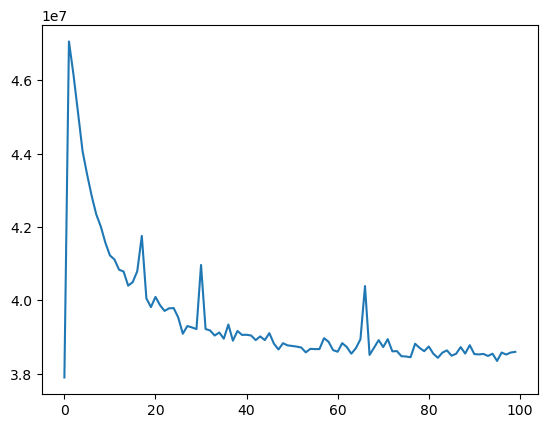

In [18]:
plt.plot(loss_list)

For comaprison, below is the loss plot when using default (larger) values for alpha. Note, that during training alpha is decreasing linearly from start value to end value. With default values in use the loss goes down near the end, once alpha gets smaller values.

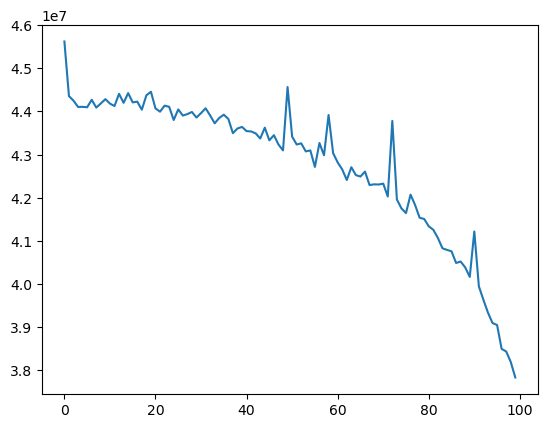

In [19]:
default_alpha_loss_list = [45621836.0, 44355904.0, 44249936.0, 44104492.0, 44107028.0, 44097436.0, 44270596.0, 44089604.0, 44185456.0, 44285424.0, 44182396.0, 44126032.0, 44408908.0, 44199988.0, 44425624.0, 44209516.0, 44227556.0, 44041368.0, 44373620.0, 44456688.0, 44070200.0, 43995008.0, 44134528.0, 44107632.0, 43802268.0, 44047244.0, 43904480.0, 43939264.0, 43987436.0, 43859148.0, 43961468.0, 44073332.0, 43907992.0, 43725336.0, 43849884.0, 43924944.0, 43826232.0, 43496588.0, 43605268.0, 43641544.0, 43543980.0, 43537204.0, 43491140.0, 43373268.0, 43624628.0, 43330720.0, 43449924.0, 43234040.0, 43097712.0, 44565932.0, 43416728.0, 43234072.0, 43260536.0, 43074152.0, 43096868.0, 42714596.0, 43268708.0, 42984456.0, 43917916.0, 43035192.0, 42818392.0, 42656488.0, 42411144.0, 42707748.0, 42523348.0, 42491780.0, 42605616.0, 42294312.0, 42310540.0, 42306532.0, 42327836.0, 42028380.0, 43780020.0, 41960848.0, 41753348.0, 41644528.0, 42072300.0, 41830796.0, 41535968.0, 41507712.0, 41336916.0, 41256888.0, 41069008.0, 40828812.0, 40791320.0, 40758012.0, 40487952.0, 40521400.0, 40385292.0, 40164828.0, 41217672.0, 39945608.0, 39633816.0, 39335348.0, 39096012.0, 39050096.0, 38497092.0, 38436708.0, 38193532.0, 37834140.0]
plt.plot(default_alpha_loss_list)

In [20]:
model.wv.most_similar('сабака', topn=20)

[('котка', 0.8660191893577576),
 ('кошка', 0.8606441617012024),
 ('кот', 0.8568669557571411),
 ('жывёліна', 0.8529811501502991),
 ('дзік', 0.8501656651496887),
 ('кацяня', 0.8330008387565613),
 ('конь', 0.8250272870063782),
 ('пацук', 0.8216575980186462),
 ('сабачка', 0.818630039691925),
 ('воўк', 0.8142035603523254),
 ('муха', 0.8140349984169006),
 ('асёл', 0.8029661774635315),
 ('звер', 0.802895724773407),
 ('авечка', 0.8020086884498596),
 ('малпа', 0.798290491104126),
 ('лісіца', 0.7959965467453003),
 ('каза', 0.7891339659690857),
 ('шчанюк', 0.7891247868537903),
 ('мядзведзь', 0.7870652079582214),
 ('свіння', 0.7852128744125366)]

In [21]:
model.wv.index_to_key[:10]

['быць',
 'год',
 'беларускі',
 'беларусь',
 'чалавек',
 'магчы',
 'час',
 'усё',
 'дзень',
 'большыць']

In [22]:
# tsne for visualization
# plotly for interactivity https://towardsdatascience.com/how-to-train-a-word2vec-model-from-scratch-with-gensim-c457d587e031
# save filtered out wods into separat file to verify
# dont explicitly list stop words
# prepare assessment data (50 words with 10 most similar wods for them)
# remove words after training
# increase corpus
# increase dimensionality
# merge е/ё , e.g. пачуцце/пачуццё
# п'еса is split to 'п' і 'еса'

In [23]:
model.save("word2vec-100-bel-cc100.model")

INFO:gensim.utils:Word2Vec lifecycle event {'fname_or_handle': 'word2vec-100-bel-cc100.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-05-16T20:45:10.903641', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'saving'}
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved word2vec-100-bel-cc100.model


In [24]:
model.wv.save_word2vec_format('word2vec-100-bel-cc100.vectors')

INFO:gensim.models.keyedvectors:storing 79373x100 projection weights into word2vec-100-bel-cc100.vectors
